In [2]:
%pip install osmnx geopandas matplotlib contextily

Note: you may need to restart the kernel to use updated packages.


In [1]:
import osmnx as ox

#Standard OSMnx settings
ox.settings.log_console = True
ox.settings.use_cache = True

#Munich walkable network
G = ox.graph_from_place("Munich, Germany", network_type="walk")

Nodes: 136674, Edges: 358470


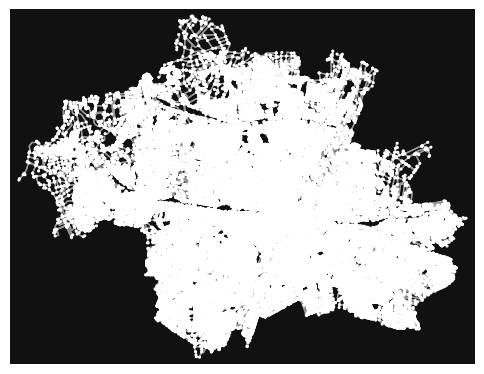

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [ ]:
#Checking the graph
print(f"Nodes: {len(G.nodes)}, Edges: {len(G.edges)}")
ox.plot_graph(G, node_size=5, figsize=(6, 6))


In [2]:
#Setting Marienplatz as center
marienplatz_point = (48.137154, 11.576124)
center_node = ox.distance.nearest_nodes(G,
                                        X=marienplatz_point[1],
                                        Y=marienplatz_point[0])
print(f"Marienplatz: {center_node}")


Marienplatz: 701279568


In [3]:
#Converting the graph distance to meters
G_proj = ox.project_graph(G)
node_proj = ox.project_graph(G).nodes[center_node]


In [ ]:
import networkx as nx

#Defining thresholds in meters
speed_mps = 1.39 #Assuming average walking speed is 5 km/h which translates to 1.39 m/s
times = [5, 10, 15]  #Minutes
distances = [speed_mps * t * 60 for t in times]

#Extracting required subgraphs for each threshold
subgraphs = {}
for t, dist in zip(times, distances):
    subG = nx.ego_graph(G_proj, center_node, radius=dist, distance="length")
    subgraphs[t] = subG #All nodes reachable from Marienplatz within the specified time at average walking speed of 5 km/h
    print(f"{t}-min subgraph: {len(subG.nodes)} nodes, {len(subG.edges)} edges")


5-min subgraph: 354 nodes, 958 edges
10-min subgraph: 1124 nodes, 3024 edges
15-min subgraph: 2905 nodes, 7898 edges


In [ ]:
#Converting each subgraph to it's corresponding geodata polygon
#Used external resources for this section......needed the help xD
import geopandas as gpd
#from shapely.ops import unary_union

isochrones = []

for t, subG in subgraphs.items():
    #Coverted edge geometries to GeoDataFrame
    gdf_edges = ox.graph_to_gdfs(subG, nodes=False, edges=True)
    
    #Generate the boundary by dissolving into one multilinestring, buffer, and get the outer ring
    #multi_line = unary_union(gdf_edges.geometry)
    multi_line = gdf_edges.geometry.union_all()
    poly = gpd.GeoSeries([multi_line.buffer(50)])
    poly = poly.buffer(0).union_all()
    
    #Saving as GeoDataFrame
    isochrones.append(
        {"time_min": t, "geometry": poly}
    )

iso_gdf = gpd.GeoDataFrame(isochrones, crs=gdf_edges.crs)
print(iso_gdf)


C:\Users\faiva\AppData\Local\Temp\ipykernel_4800\967400429.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = poly.buffer(0).unary_union
C:\Users\faiva\AppData\Local\Temp\ipykernel_4800\967400429.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = poly.buffer(0).unary_union
C:\Users\faiva\AppData\Local\Temp\ipykernel_4800\967400429.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = poly.buffer(0).unary_union


   time_min                                           geometry
0         5  POLYGON ((691256.945 5334853.838, 691256.93 53...
1        10  POLYGON ((690855.061 5334963.471, 690854.986 5...
2        15  POLYGON ((690442.682 5334976.083, 690442.661 5...


C:\Users\faiva\AppData\Local\Temp\ipykernel_4800\967400429.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  poly = poly.buffer(0).unary_union


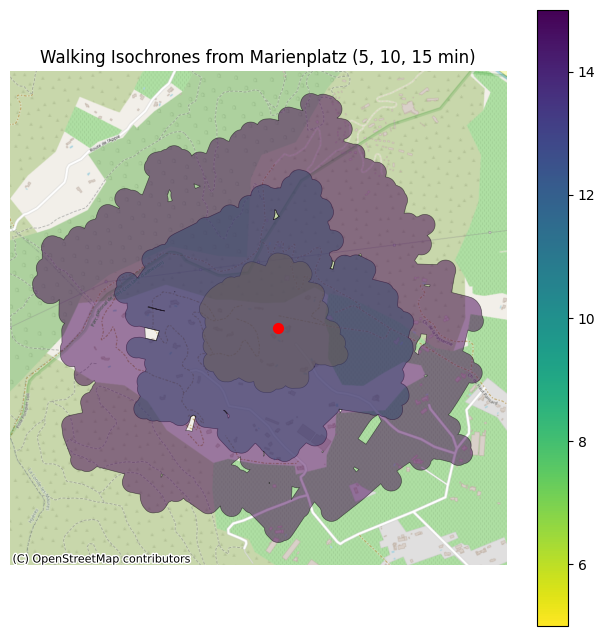

In [ ]:
#Overlap the reachable walking polygons on top of Munich map from contextily
import matplotlib.pyplot as plt
import shapely.geometry as geom
import contextily as ctx

#Plotting
fig, ax = plt.subplots(figsize=(8, 8))
iso_gdf.plot(column="time_min",
             cmap="viridis_r",
             alpha=0.5,
             linewidth=0.5,
             edgecolor="black",
             legend=True,
             ax=ax)

#Added marker for Marienplatz
marienplatz_geom = gpd.GeoSeries([geom.Point(node_proj['x'], node_proj['y'])], crs=G_proj.graph['crs'])
marienplatz_geom.plot(ax=ax, color="red", markersize=50)

#Add Munich basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.DE)
ax.set_axis_off()
plt.title("Walking Isochrones from Marienplatz (5, 10, 15 min)")
plt.show()
